In [1]:
# Importing libraries
import random
import os
import PIL
import numpy as np
import matplotlib.pyplot as plt
from easyimages import EasyImageList
import re

random.seed(42)

# Data Exploration

### Image Exploration
* Print the count of images
* Print dimension

In [2]:
PROJECT_DIR = os.getcwd()  # get the current working directory
DATA_DIR = os.path.join(PROJECT_DIR, 'data') # Concatenate the folder name which contains images
DATA_DIR  # Check the final path value

'/home/bairathirahul/Workspace/image-captioning/data'

In [3]:
# Point to the memes folder from the data directory
meme_images_dir = os.path.join(DATA_DIR, "memes")
meme_images = os.listdir(meme_images_dir)  # get the meme template filenames from the path
print(f'The meme image file names : {meme_images}')

The meme image file names : ['thumbs-up-steve.jpg', 'bane-permission-to-die.jpg', 'gena-orlov.jpg', 'julia-gillard.jpg', 'a-mi-no-me.jpg', 'irresponsible-nyan-cat.jpg', 'guffdead.jpg', 'friendly-creepy-guy.jpg', 'craig-would-be-so-happy.jpg', 'bigyan-ng-jacket.jpg', 'sarcastic-wonka.jpg', 'very-optimistic-smile.jpg', 'typical-proger.jpg', 'stoner-stanley.jpg', 'people-are-fucking-stupid.jpg', 'anxiety-cat.jpg', 'anti-joke-castiel.jpg', 'chibolo-de-mierda.jpg', 'tony-montana.jpg', 'good-guy-gregs-dog.jpg', 'andr-villas-boas.jpg', 'chan-chan.jpg', 'carl-spackler.jpg', 'chadbrochill.jpg', 'regretting-panda.jpg', 'typical-aussie.jpg', 'tegaki-rp-tuna.jpg', 'bad-billie-joe.jpg', 'the-wtf-mordecai.jpg', 'quirky-turkey.jpg', 'typical-fans-the-x-files.jpg', 'please-guy.jpg', 'bad-luck-drizzy.jpg', 'know-it-all-student.jpg', 'crying-face.jpg', 'oh-kakashi.jpg', 'bill-murray-caddyshack.jpg', 'x-is-bad-and-you-should-feel-bad.jpg', 'terry-tibbs.jpg', 'socially-awesome-awkward-penguin.jpg', 'james

In [4]:
# Visual inspection of the meme images

# Creates an EasyImageList object representing all images in folder and assigns it to the variable list
image_list = EasyImageList.from_folder(meme_images_dir)  
# Display the randomly selected subset of images in the HTML format
image_list.html(sample=500, size = 50)

In [5]:
# Collect memes file attributes
meme_images_count = 0  # variable to keep the count of number of images
meme_images_broken = 0
meme_images_filetypes = {}
meme_images_widths = []
meme_images_heights = []
meme_images_dimensions = {}
meme_images_aspect_ratio = []
meme_images_modes = {}
meme_images_blank = {}

for image_file in meme_images:  # Iterate on every meme template image
    try:
        image = PIL.Image.open(os.path.join(meme_images_dir, image_file))        

        # image count
        meme_images_count += 1

        # Get the count of different extensions for the image
        meme_images_filetypes[image.format] = meme_images_filetypes.get(image.format, 0) + 1 
        

        # # read image file type
        # meme_images_filetypes[image_file.split(".")[-1]] = (
        #     meme_images_filetypes.get(image_file.split(".")[-1], 0) + 1
        # )

        # retrieve the color mode of each of the image
        meme_images_modes[image.mode] = meme_images_modes.get(image.mode, 0) + 1 

        # get the image dimensions       
        meme_images_widths.append(image.size[0])  
        meme_images_heights.append(image.size[1])

        # get the count of images for each unique dimension
        meme_images_dimensions[image.size] = meme_images_dimensions.get(image.size, 0) + 1  

        # determine the aspect ratio of the image
        aspect_ratio = image.size[0] / image.size[1]
        meme_images_aspect_ratio.append(aspect_ratio)

        # determine if image is blank (extrema gives the value of the darkest and lightest pixel)
        # Convert the RGB image to a greyscale and get the extreme pixel values
        extrema = image.convert("L").getextrema()
        # if both the extreme values are same, then the image is just in one color, i.e there is nothing in image (later on we will check what is the caption for the image)
        if extrema[0] == extrema[1]:
            # get the image file and the value of the pixel
            meme_images_blank[image_file] = extrema[0]

        # close the image
        image.close()

    # Exception handling
    except Exception as e:
        print("Could not read image file {}".format(image_file), e)
        meme_images_broken += 1

        
# Print all the variables
print("Total memes: {}".format(meme_images_count))
print("Broken memes: {}".format(meme_images_broken))
print("Meme file types: {}".format(meme_images_filetypes))
print("Meme modes: {}".format(meme_images_modes))
print("Meme dimensions: {}".format(meme_images_dimensions))
print("Blank memes: {}".format(meme_images_blank))

Total memes: 2504
Broken memes: 0
Meme file types: {'JPEG': 2504}
Meme modes: {'RGB': 2504}
Meme dimensions: {(250, 250): 2461, (225, 225): 5, (150, 150): 1, (232, 232): 1, (227, 227): 2, (200, 200): 3, (224, 224): 2, (199, 199): 1, (248, 248): 1, (240, 240): 2, (210, 210): 1, (170, 170): 1, (183, 183): 1, (213, 213): 1, (180, 180): 1, (226, 226): 1, (135, 135): 1, (245, 245): 1, (230, 230): 2, (195, 195): 1, (208, 208): 1, (220, 220): 2, (216, 216): 2, (211, 211): 1, (194, 194): 1, (128, 128): 1, (174, 174): 1, (233, 233): 1, (197, 197): 1, (157, 157): 1, (360, 356): 1, (222, 222): 1}
Blank memes: {'blank-template.jpg': 255, 'blank-black.jpg': 0}


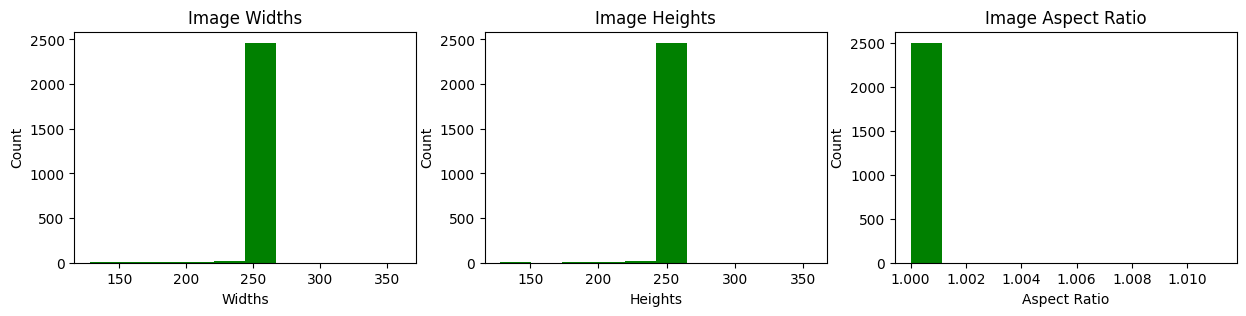

In [6]:
# Get the distribution on the different widths, heights and the aspect ratio of the images
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(15, 3))

ax[0].hist(meme_images_widths, bins=10,color='green')
ax[0].set_title('Image Widths')
ax[0].set_xlabel('Widths')
ax[0].set_ylabel('Count')

ax[1].hist(meme_images_heights, bins=10,color='green')
ax[1].set_title('Image Heights')
ax[1].set_xlabel('Heights')
ax[1].set_ylabel('Count')

ax[2].hist(meme_images_aspect_ratio, bins=10,color='green')
ax[2].set_title('Image Aspect Ratio')
ax[2].set_xlabel('Aspect Ratio')
ax[2].set_ylabel('Count')

plt.show()

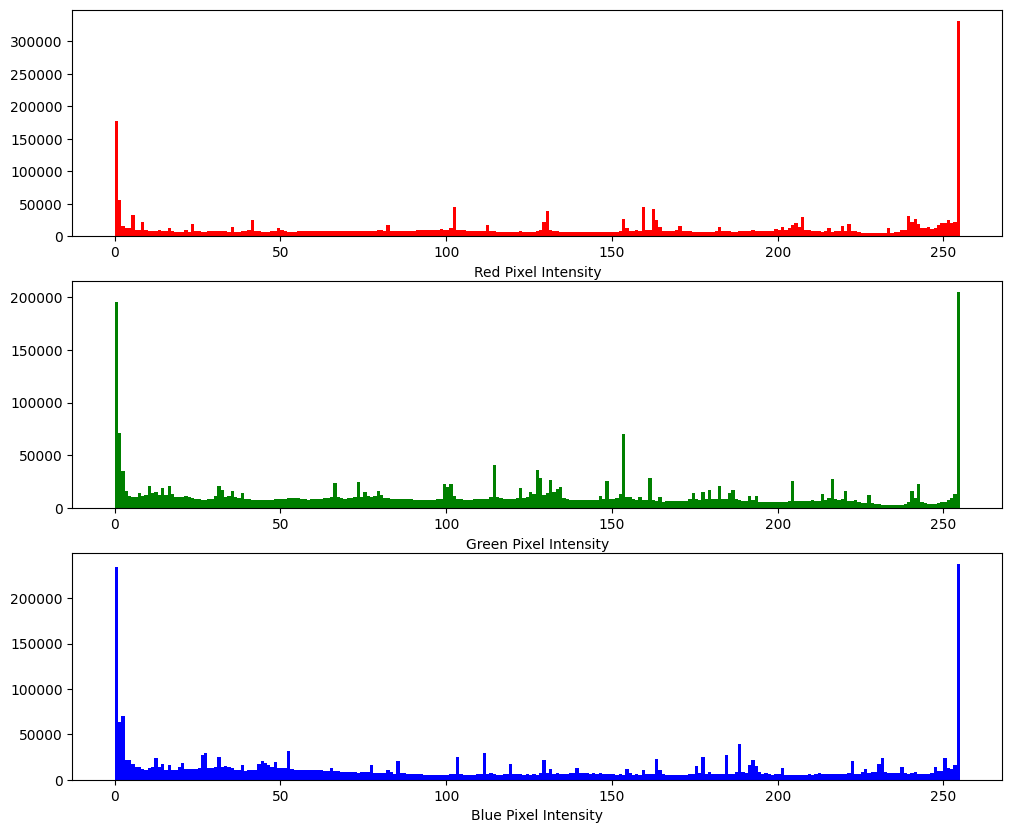

In [7]:
# Image color distribution
colors = {"R": [], "G": [], "B": []}

# For the 50 random images, plot the color distribution
for image_file in random.sample(meme_images, 50):
    image = PIL.Image.open(os.path.join(meme_images_dir, image_file))

    image_array = np.array(image)

    colors["R"].extend(image_array[:, :, 0].flatten())
    colors["G"].extend(image_array[:, :, 1].flatten())
    colors["B"].extend(image_array[:, :, 2].flatten())

    image.close()

# Plot color distribution
fig, ax = plt.subplots(3, 1, figsize=(12, 10))
ax[0].hist(colors["R"], bins=255, color = 'red')
ax[0].set_xlabel("Red Pixel Intensity")

ax[1].hist(colors["G"], bins=255, color = 'green')
ax[1].set_xlabel("Green Pixel Intensity")

ax[2].hist(colors["B"], bins=255, color = 'blue')
ax[2].set_xlabel("Blue Pixel Intensity")

plt.show()

# Captions Text Exploration

In [8]:
captions = open(os.path.join(DATA_DIR, "captions.txt"), "r").read()

meme_names = {} # dictionary to store image filename and the meme name
meme_captions = {} # dictionary to store the image filename and the meme captions

previous_filename = None

# Collect memes and their associated captions
for line in captions.split("\n"):
    # if the line does not contain a dash, it is a continuation of the previous caption
    if line.find('-') == -1 and previous_filename is not None:
        meme_captions[previous_filename][-1] += " " + line.strip()
        continue
        
    # Find the index of the dash which separates the image name and the caption
    split_index = line.index(' - ')
    name, caption = line[0:split_index].strip(), line[split_index + 3:].strip()

    # Ignore the empty meme caption
    if not caption:
        continue

    # generate meme template file name - remove special characters and convert to lowercase
    meme_image_filename = re.sub(r"[^a-zA-Z0-9]+", '', name.lower()) + ".jpg"

    meme_names[meme_image_filename] = name
    meme_captions[meme_image_filename] = meme_captions.get(meme_image_filename, []) + [caption]

    previous_filename = meme_image_filename

random.sample(sorted(meme_captions.items()), 5)

[('lolcat.jpg',
  ["Samanta baby i'm ready for you, my love",
   'reow',
   'I tRies To sleep',
   'I can HAz Sleepovers',
   'u can haz cuddlez',
   'Jesus sid: I saw you while you were stll under the fig tree Nathaniel: What!? You Stalker!',
   "PLACEHOLDER FOR FUTURE SECTION THAT WE'RE WORKING VERY HARD ON.",
   'My Owner  IS AN IDIOT',
   'Yes hunter... even lolcats',
   "DON'T F** WITH MY ASHTRAY!",
   'NO U LAUGH AT MY ASHTRAY!',
   'NO U LAUGH AT MY ASHTRAY!',
   'NO U LAUGh At mY ASHTRAY!',
   'NO U LAUGH AT MY ASHTRAY!',
   "Tony abbott Doesn't Understand THe Internet This is what you use it for",
   'Life Hard party harder',
   'no new one until i get a proper reply',
   'http://bit.ly/KaNBOk',
   "I can't haz access to ur outlooks I checks the sharepoint and PTo doesn't ekzist.",
   "I haz question but i don't want to leave my seat.",
   "I haz question but i don't want to leave my seatz",
   'I is in your test code Editing your test code',
   'I made you a nutella cake but 

In [9]:
# Find duplicate filenames after removing dash
memes_without_dash = {}
for filename in meme_images:
    filename_without_dash = filename.replace('-', '')
    memes_without_dash[filename_without_dash] = memes_without_dash.get(filename_without_dash, []) + [filename]

for key, val in memes_without_dash.items():
    if len(val) > 1:
        print(key, val)

pleaseguy.jpg ['please-guy.jpg', 'pleaseguy.jpg']
vaultboy.jpg ['vaultboy.jpg', 'vault-boy.jpg']
idiotnerdgirl.jpg ['idiot-nerd-girl.jpg', 'idiot-nerdgirl.jpg']
businesscat.jpg ['business-cat.jpg', 'businesscat.jpg']
rainbowdash.jpg ['rainbow-dash.jpg', 'rainbowdash.jpg']
angrydoctor.jpg ['angry-doctor.jpg', 'angrydoctor.jpg']
billoreillyfuckit.jpg ['bill-oreilly-fuck-it.jpg', 'bill-o-reilly-fuck-it.jpg']
omskcrow.jpg ['omsk-crow.jpg', 'omskcrow.jpg']
overlymanlyman.jpg ['overly-manly-man.jpg', 'overly-manlyman.jpg']
censochile.jpg ['censochile.jpg', 'censo-chile.jpg']
antijokechicken.jpg ['anti-joke-chicken.jpg', 'antijokechicken.jpg']
overlyattachedboyfriend.jpg ['overly-attached-boyfriend.jpg', 'overly-attached-boy-friend.jpg']
musicnerdoctopus.jpg ['musicnerdoctopus.jpg', 'music-nerd-octopus.jpg']
yuno.jpg ['y-u-no.jpg', 'yu-no.jpg']
slenderman.jpg ['slenderman.jpg', 'slender-man.jpg']
angryschoolboy.jpg ['angry-school-boy.jpg', 'angryschoolboy.jpg']


In [10]:
# Find the meme templates with no captions
no_captions = set(memes_without_dash.keys()) - set(meme_captions.keys())
print(len(no_captions))
no_captions

32


{'TutorPP.jpg',
 'allefobommoo.jpg',
 'andrvillasboas.jpg',
 'carois1.jpg',
 'codaxanacasadossegredos3.jpg',
 'duvetattdursvensknr.jpg',
 'funes20aos.jpg',
 'kibrndultrtelmisgi.jpg',
 'lunaloonylovegood.jpg',
 'miit.jpg',
 'mindenkinyugodjonleapicsba.jpg',
 'msugeofuck.jpg',
 'niomalvadoeviltoddler.jpg',
 'nobastaserpobre.jpg',
 'okay.jpg',
 'oseaquepedo.jpg',
 'oseaqupedomem.jpg',
 'quhorror.jpg',
 'quiendiceenchufetv.jpg',
 'sbpgti.jpg',
 'stavropoltypical.jpg',
 'taemin.jpg',
 'tiffanybitchplease.jpg',
 'tipicalgornyak.jpg',
 'tpicaabuela.jpg',
 'typicallub.jpg',
 'typicalshatura.jpg',
 'unclesi.jpg',
 'uysipeapia.jpg',
 'vitakrnktamannen.jpg',
 'vrn.jpg',
 'yaqupondrasituvierauno.jpg'}

In [11]:
no_image = set(meme_captions.keys()) - set(memes_without_dash.keys())
print(len(no_image))
no_image

3


{'duckdynasty.jpg', 'releasethekraken.jpg', 'snsd.jpg'}

In [12]:
# Remove the meme templates with no captions
for filename in no_image:
    meme_captions.pop(filename)
    meme_names.pop(filename)

Text Pre-processing

* Remove multiple spaces
* Convert text to lowercase
* Convert non-english to english
* Convert contractions
* 

In [13]:
import contractions

def preprocess_captions(caption):
    """
    Preprocess the captions of the memes
    """
    
    # Remove multiple spaces and multiple punctuation marks
    caption = re.sub(r"\s+", " ", caption)
    caption = re.sub(r"([.?!])\1+", r"\1", caption)

    # Remove non-ascii characters
    caption = "".join(i for i in caption if ord(i) < 128)

    # Remove URLs
    caption = re.sub(r"http\S+", "", caption)

    # Expand contractions
    caption = contractions.fix(caption)

    # Split the words joined with hypen
    caption = re.sub(r"([a-zA-Z0-9])[-\/]([a-zA-Z0-9])", r"\1 \2", caption)

    return caption.lower()

print(preprocess_captions('Sono economicamente messi peggio di noi italiani riescono a permettersi una rete migliore della nostra, tanto da definirsi "Iper-connessionati"'))
print(preprocess_captions('I told him we\'re sending the national un-watering team!'))
print(preprocess_captions('I told-him-we-are - a/team!'))

sono economicamente messi peggio di noi italiani riescono a permettersi una rete migliore della nostra, tanto da definirsi "iper connessionati"
i told him we are sending the national un watering team!
i told him we are - a team!


In [14]:
# Remove duplicate captions from the array
for filename, captions in meme_captions.items():
    # Pre-process captions
    captions = list(map(preprocess_captions, captions))

    # Remove duplicate captions
    original_length = len(captions)
    meme_captions[filename] = list(set(captions))
    new_length = len(meme_captions[filename])

    if original_length != new_length:
        print("Removed {} duplicate captions from {}".format(
            original_length - new_length, filename
        ))

Removed 11 duplicate captions from yuno.jpg
Removed 4 duplicate captions from themostinterestingmanintheworld.jpg
Removed 2 duplicate captions from futuramafry.jpg
Removed 1 duplicate captions from successkid.jpg
Removed 5 duplicate captions from onedoesnotsimply.jpg
Removed 1 duplicate captions from badluckbrian.jpg
Removed 1 duplicate captions from firstworldproblems.jpg
Removed 5 duplicate captions from grumpycat.jpg
Removed 2 duplicate captions from foreveralone.jpg
Removed 1 duplicate captions from goodguygreg.jpg
Removed 1 duplicate captions from scumbagsteve.jpg
Removed 2 duplicate captions from whatifitoldyou.jpg
Removed 1 duplicate captions from kermitthefrogdrinkingtea.jpg
Removed 5 duplicate captions from yodawg.jpg
Removed 2 duplicate captions from allthethings.jpg
Removed 5 duplicate captions from insanitywolf.jpg
Removed 1 duplicate captions from josephducreux.jpg
Removed 4 duplicate captions from pedobear.jpg
Removed 1 duplicate captions from trollface.jpg
Removed 1 dupl

In [15]:
meme_captions['snoopdogg.jpg']

['hare krishnizzle',
 'joint tenant',
 'this is for the quiche and this is for the kassler',
 'i will chuck norris dat muthafucka',
 'fo shizzle my nizzle',
 '100 my nizzle',
 'ya mean. no hoes?!?',
 'sssup bros?',
 'wit so much drama on the i.r.c. its kind of hard being snoop d.o double g',
 'pitchbook is for snoops',
 'i have a pony tail',
 'la di da di i gots ta potty',
 'trap music you best drop that like its hot cuz its not',
 'you just call me vato? essay',
 'so i heard you like to view stuff so i got a viewer to view a wiewer so you can view the viewer while you view',
 'neger, ich hasse canabis',
 'tacos margaritas',
 'i miss my dogg',
 'snoop says chizzle them dizzles you all',
 'hickory dickory dock this bitch was suckin my cock the clock struck two i blew my goo and dumped her at the end of the block.',
 'motherfucker give me yo change',
 'raps about being young, wild, and free is 40 years old and married with kids',
 'po bizzle in the hizzle',
 'with so much drama on audizi

In [16]:
from torchtext.data import get_tokenizer

# Generate vocabulary in this state
tokenizer = get_tokenizer("basic_english")
vocab = []
for filename, captions in meme_captions.items():
    for caption in captions:
        vocab.extend(tokenizer(caption))

print("Vocabulary size: {}".format(len(set(vocab))))

Vocabulary size: 148502


In [17]:
from collections import Counter

# Count the occurrence of words in vocabulary
wordcount = Counter(vocab)
print("Least common words")

# Length of words with count 1
least_common_words = [word for word, count in wordcount.items() if count == 2 and len(word) > 20]
least_common_words

Least common words


['mayoupleasrepethaword',
 'fuuuuuuuuuuuuuuuuuuuuuuuuuuuuu',
 'ssssssssssssssssssssss',
 'ahahahahahahahahahaha',
 'nooooooooooooooooooooo',
 'nooooooooooooooooooooooooo',
 'scienceofrelationships',
 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx',
 'ooooooooooooooooooooooooooo',
 'hugssssssssssssssssss',
 'creaturessssssssssssss',
 '---------------------',
 'bestgurlfriendsforlife',
 'nyannyannyannyannyannyan',
 'hahahahahahahahahahahaha',
 '1415926535897932384626433832795028841971693993751058209',
 '7494459230781640628620899862803482534211706798214808651',
 'grrrrrrrrrrrrraaaaiiiii',
 'trololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololol',
 'trololololololololololo',
 'trololololololololololololololololololololololololololololololololololo

In [18]:
# Replace the least common words with <unk>

for filename, captions in meme_captions.items():
    for i, caption in enumerate(captions):
        captions[i] = " ".join(
            [
                "<unk>" if word in least_common_words else word
                for word in tokenizer(caption)
            ]
        )

In [19]:
# Remove all captions with just <unk>, less than 3 tokens and just punctuations

def is_valid_caption(caption):
    """
    Check if the caption is valid
    """

    tokens = tokenizer(caption)

    if len(tokens) < 3:
        return False
    
    if set(tokens) == {"<unk>"}:
        return False
    
    tokens_without_punctuations = list(filter(lambda x: x.isalnum(), tokens))
    if set(tokens_without_punctuations) == '':
        return False
    
    return True

for filename, captions in meme_captions.items():
    original_count = len(captions)
    captions = list(filter(is_valid_caption, captions))
    new_count = len(captions)

    if original_count != new_count:
        print("Removed {} captions from {}".format(original_count - new_count, filename))
        
    meme_captions[filename] = captions

Removed 4 captions from yuno.jpg
Removed 1 captions from badluckbrian.jpg
Removed 1 captions from foreveralone.jpg
Removed 1 captions from goodguygreg.jpg
Removed 1 captions from scumbagsteve.jpg
Removed 1 captions from kermitthefrogdrinkingtea.jpg
Removed 1 captions from allthethings.jpg
Removed 1 captions from josephducreux.jpg
Removed 2 captions from pedobear.jpg
Removed 3 captions from trollface.jpg
Removed 1 captions from skeptical3rdworldkid.jpg
Removed 1 captions from disastergirl.jpg
Removed 3 captions from slowpoke.jpg
Removed 59 captions from drevilmeme.jpg
Removed 1 captions from adviceyodagives.jpg
Removed 5 captions from stonerstanley.jpg
Removed 21 captions from pleaseguy.jpg
Removed 4 captions from koalacantbelieveit.jpg
Removed 2 captions from batmanslaprobin.jpg
Removed 4 captions from mrbean.jpg
Removed 1 captions from butthurtdweller.jpg
Removed 6 captions from deskfliprageguy.jpg
Removed 2 captions from drunkbaby1.jpg
Removed 4 captions from whyyy.jpg
Removed 7 capt

In [20]:
# Checkpoint, save the preprocessed captions file

meme_captions_flattened = [[filename, memes_without_dash[filename][0], caption] for filename, captions in meme_captions.items() for caption in captions]
np.save(os.path.join(DATA_DIR, "meme_captions.npy"), meme_captions_flattened)

In [21]:
# Find and collect non-english captions

from torchtext.data.utils import ngrams_iterator
from ftlangdetect import detect


def is_english_text(caption):
    """
    Preprocess the captions of the memes
    """

    tokens = tokenizer(caption)

    languages = [detect(text=ngram)["lang"] for ngram in ngrams_iterator(tokens, 3)]

    is_english = (
        len([lang for lang in languages if lang == "en"]) / len(languages)
    ) > 0.3

    return is_english

non_english_captions = []
# Translate captions to english
for filename, captions in meme_captions.items():
    for i, caption in enumerate(captions):
        if not is_english_text(caption):
            non_english_captions.append(caption)

print(len(non_english_captions))
random.sample(non_english_captions, 10)

28432


['er mer gerd cler , yer ersum !',
 'i am seedy who am i ? . burgo . arya !',
 'temecula memes suck .',
 'olakmo le llede la cuca',
 'fffuuuuuuucccckkkkkk ! fuck fuck fuuuuck !',
 'blowjob wooooo !',
 'hwa ento tabe3een ?',
 'america invadida terrorismo america invadindo democracia',
 'di nosa gekapta',
 'no puede ser , su nivel de puta es impresionante']

In [22]:
# Checkpoint, save the preprocessed captions file
np.save(os.path.join(DATA_DIR, "non_english_captions.npy"), non_english_captions)

In [26]:
# Translating the non-english text separately because this call might fail
import time
import json
from googletrans import Translator

# Read translation file if already exists
translations_file = os.path.join(DATA_DIR, "non_english_captions_translations.json")
if os.path.exists(translations_file):
    translated_captions = json.load(open(translations_file, "r"))
else:
    translator = Translator()

    translated_captions = {}
    i = 0
    while i < len(non_english_captions):
        try:
            print(i)
            caption = non_english_captions[i]
            translated_captions[caption] = translator.translate(caption).text
            i += 1
        except:
            time.sleep(30)

    with open(
        os.path.join(DATA_DIR, "non_english_captions_translations.json"), "w"
    ) as f:
        json.dump(translated_captions, f)

random.sample(list(translated_captions.items()), 10)

[('dachte ich hab die fotze vergessen ( es tut immer noch weh',
  'I thought I forgot about the pussy (it still hurts'),
 ('i am hitler', 'i am hitler'),
 ('acabou meu cremogema them casa ? culpa do pt !',
  "I finished creaming them home? pt's fault!"),
 ('mene helvettiin harrastan kirkkobongausta',
  "go to hell I'm into church banging"),
 ('buna costel cand mai treci pe la mine ? *',
  'hello, when are you coming to visit me again? *'),
 ('dhe pastaj i thashe sueles qe shyqyr qe ka goca si ti qe sjane materialiste',
  'and then I told Suela that I am thankful that there are girls like you who are materialistic'),
 ('cuando andas borracha me dices k me kieres pero cuando no tomas te caigo mal .',
  "When you're drunk you tell me you love me but when you don't drink you don't like me."),
 ('esa es tu novia ? uyyy ya me la heche',
  "that's your girlfriend ? oops I already did it"),
 ('soy lewi y se me moja la canoa', "I'm Lewi and my canoe gets wet"),
 ('malungkot si paul ? ialay si f

In [28]:
# Apply the translated captions to the meme_captions dictionary

for filename, captions in meme_captions.items():
    for i, caption in enumerate(captions):
        if caption in translated_captions:
            meme_captions[filename][i] = translated_captions[caption]

In [29]:
# Save the final data file

# Checkpoint, save the preprocessed captions file

meme_captions_flattened = [[filename, memes_without_dash[filename][0], caption] for filename, captions in meme_captions.items() for caption in captions]
np.save(os.path.join(DATA_DIR, "meme_captions.npy"), meme_captions_flattened)